In [6]:
from setup import (load_models,
                   convert_arg_to_list,
                   )
import pandas as pd
import ast
import itertools
import re
import json
import ast

n_combos = 50
gene_combos = pd.read_csv('./Data/GeneCombos.csv',header=None)[0][:n_combos]
DG_list = list(ast.literal_eval(ele) for ele in gene_combos)

# E0, S0, all_components = load_models()
# gr_DG = pd.read_csv('./r/data fitting/Data/gr_Div_DG_checkerboard_standardized_ByNoDrug.csv', index_col='Gene_inhibition')
# gr_DG.loc[:,:'S0_monoculture'][gr_DG.loc[:,:'S0_monoculture']<1e-5] = 0 

# label_df = pd.read_excel(open('./Data/iML1515_GP.xlsx', 'rb'), # ? S0 rct pathway label necessary?
#               sheet_name='iML1515_GP', index_col=0)
# rct_pathway_df = pd.read_csv('./Data/rct_pathway.csv')
# alpha_table = pd.read_csv("./Data/alpha_table.csv", index_col=0)
alpha_table = pd.read_csv("./Data/checkerboard_alpha_table.csv", index_col=0)
if len(alpha_table.columns) == 3:
    alpha_table.columns = ['E0', 'S0.ac', 'S0.glc']
else:
    alpha_table.lv_pairs = alpha_table.lv_pairs.apply(ast.literal_eval)

# comb_list = list(pd.read_csv('./Data/gr_Div_DG_Blis_Aug31.csv').gene_inhibition[1:])
# DG_list = list(gr_DG.index)
if 'Normal' in DG_list:
    DG_list.remove('Normal')

def convert_arg_to_list(arg):
    if isinstance(arg, (pd.Series, pd.Index)):
        arg = list(arg) 
    elif not isinstance(arg, (list, tuple, set)):
        arg = [arg] # differ from list(arg) -> conversion of str
    return arg

def get_Biomass_df(files):
    return pd.concat(
            [pd.read_csv(file, index_col='cycle')
             for file in convert_arg_to_list(files)]
        ,axis=1)

# Biomass_df = get_Biomass_df(['./Data/BM_SG1.csv', './Data/BM_DG1.csv'])
# Biomass_df = get_Biomass_df(['C:/Users/wongt/OneDrive/COMETS_Jupyter/Run_Comets/r/data fitting/Data/checkerboard_run3.csv'])
Biomass_df = get_Biomass_df(['./Data/checkerboard_run4.csv'])

In [8]:
log_step=5

def search_gr_cycle_with_biomass(df_search, biomass_values):
    return [df_search[df_search >= biomass_value].idxmin() 
                for biomass_value in list(biomass_values)]

def get_maximum_growth_cycle(desired_BM):
    c_max_gr = desired_BM.iloc[1]+ (desired_BM.iloc[-1] - desired_BM.iloc[1])/2
    bool_growing = ((desired_BM.iloc[-1]-desired_BM.iloc[-5])/desired_BM.iloc[-1]).apply(lambda x: x > 1e-10)
    for k, bool_grow in bool_growing.items():
        if bool_grow:
            c_max_gr[k] = desired_BM[k].iloc[-6]
    biomass_diff = (desired_BM.iloc[-1]-desired_BM.iloc[0])
    start = desired_BM.iloc[0] + biomass_diff*0.1
    end = desired_BM.iloc[0] + biomass_diff*0.9
    return c_max_gr, start, end, bool_growing

# def find_down_neighbour(df):
#     max_gr = get_cycle_max_gr(df)
#     position = list()
    
#     def correct_cycle(cycle):
#         mod = cycle%log_step
# #         return cycle if mod==0 else cycle+log_step-mod # round up
#         return cycle if mod==0 else cycle-mod # round down
# #   
#     gr_cycle = defaultdict(dict)
#     for gcomb, biomass_value in max_gr.items():
#         df_search = df.loc[:,gcomb]
#         upperneighbour_ind =  search_gr_cycle_with_biomass(df_search, biomass_value) # 0 if growth belolw 1e-8 
# #         gr_cycle[gcomb] = correct_cycle(upperneighbour_ind) 
#         gr_cycle[gcomb].update({'cycle': correct_cycle(upperneighbour_ind),
#                                 'growth phase': [search_gr_cycle_with_biomass(),
#                                                 search_gr_cycle_with_biomass()]})
#     return gr_cycle

# def get_desired_cycle_df():
#     desired_cycle_dict = defaultdict(dict)
#     for k, cycle in find_down_neighbour(Biomass_df).items():
#         key_items = k.split('_')
#         gcomb = key_items.pop(1)
#         col_name = '_'.join(key_items)
#         if desired_cycle_dict[gcomb].get(col_name):
#             sys.exit("Halt, Gene comb keys get overwritten")
#         desired_cycle_dict[gcomb].update({col_name: cycle})

#     return pd.DataFrame.from_dict(desired_cycle_dict, orient='index')


def get_desired_cycle(Biomass_df, log_step=5):
    def correct_cycle(cycle): # 
        if cycle < log_step:
            return log_step
        return round(cycle / log_step) * log_step

    def get_growth_phase_length():
        return ((desired_cycle['end'] - desired_cycle['start'])*(1-desired_cycle.bool_growing) + # if not growing, not changing growth phase length
                1e4*(desired_cycle.bool_growing)) #if growing, set growth length to 999
    
    def split_index_to_cols(df):
        items = df.index.str.split('_')
        columns = ['Species', 'Gene_inhibition', 'culture']
        if len(items[0]) > 3:
            columns.extend(['alpha_lv_pairs'])
        return pd.DataFrame(items.tolist(), index=df.index, columns=columns)
    desired_biomass_df = pd.DataFrame(get_maximum_growth_cycle(Biomass_df), index=['c_max_gr', 'start', 'end', 'bool_growing'])
    
    desired_cycle = (desired_biomass_df.iloc[:-1]
                .apply(lambda x: 
                        search_gr_cycle_with_biomass(Biomass_df.loc[:,x.name],x))
                .T)
    desired_cycle['bool_growing'] = desired_biomass_df.T.bool_growing
    desired_cycle['cycle_max_gr'] = desired_cycle['c_max_gr'].apply(correct_cycle) # -> cycle_max_gr
    desired_cycle['growth_phase'] = desired_cycle[['start', 'end']].values.tolist()
    desired_cycle['growth_phase_length'] = get_growth_phase_length()
    desired_cycle['end_cycle'] = Biomass_df.index[-1]//5*5
    desired_cycle = desired_cycle.join(split_index_to_cols(desired_cycle))
#     .query('culture=="coculture"')
    if len(desired_cycle.Gene_inhibition.unique()) >1:
        desired_cycle = desired_cycle.set_index('Gene_inhibition')[['cycle_max_gr', 'bool_growing', 'growth_phase','growth_phase_length', 'Species','culture','end_cycle']]
    else:
        desired_cycle.index = ['_'.join([x[1],x[3]]) for x in desired_cycle.index.str.split('_')]
        desired_cycle.Gene_inhibition = desired_cycle.index

    return desired_cycle     

In [9]:
desired_cycle = get_desired_cycle(Biomass_df, log_step=10)


In [10]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def get_rcts_list(model, gcomb_list): 
    rcts_list = list()
    rcts_set = set()
    for i, gene in enumerate(gcomb_list):
        gene_rcts = [rct.id for rct in model.genes.get_by_id(get_gene_id(model, gene)).reactions]
        if i > 0:
            gene_rcts = list(set(gene_rcts) - rcts_set)
        rcts_list.append(gene_rcts)
        rcts_set = rcts_set | set(gene_rcts)
    return rcts_list

def adjust_flux_df(model, df, gene_combo: list, alpha_table=alpha_table): 
    # Don't use v1 cols to indicate gene_inhibition, will skip unidirectional reaction
    def query_alpha(gene_combo, alpha_table):
        splitted = gene_combo.split('.')
        if len(splitted) == 2:
            gcomb_alpha = {gene: alpha_table.loc[gene, f'{model.id}'] for gene in gene_combo.split('.')}
            # return gcomb_alpha

        # alphas
        splitted = gene_combo.split('_')
        # Gene_inhibition, lv_pair = [ele.split('.') for ele in 'folP.folA_1.2'.split('_')]
        Gene_inhibition, lv_pair = [ele.split('.') for ele in gene_combo.split('_')]
        lv_pair = tuple([int(ele) for ele in lv_pair])
        gcomb_alpha = dict()
        alpha_table = alpha_table.query('lv_pairs == @lv_pair')
        for current_gene in Gene_inhibition:
            # print(alpha_table.head())
            gcomb_alpha.update({current_gene: 
                                alpha_table.loc[current_gene, f'{model.id}']})
        return gcomb_alpha, alpha_table

    print(gene_combo)


    if 'Normal' not in gene_combo:
#         gene_combo_dict = get_gcomb_alpha_dict(gene_combo) 
        v1_cols = df.filter(regex='v1').columns
        
        # gcomb_alpha = {gene: alpha_table.loc[gene, f'{model.id}'] for gene in gene_combo.split('.')}
        gcomb_alpha, alpha_table = query_alpha(gene_combo, alpha_table)
        # print(gcomb_alpha)
        gcomb_alpha = dict(sorted(gcomb_alpha.items(), key=lambda item: item[1], reverse=True))
        
        rcts_list = get_rcts_list(model, gcomb_alpha.keys()) # exclude repeated rct for two gene
        scaled_rcts = list()
    # return df
        for gene, rcts in zip(gcomb_alpha.keys(), rcts_list):  
#             rcts = [rct for rct in rcts if rct in orig_cols]
            for orig_col in rcts:
                alpha = alpha_table.loc[f'{gene}', f'{model.id}']    
                v1_col = orig_col + "_v1"
                reversible = v1_col  in v1_cols
                if reversible: 
                    df[f'{orig_col}'] = (df[f'{orig_col}'] + df[f'{v1_col}'])/alpha # only forward or backward != 0  
                    df = df.drop(f'{v1_col}', axis=1)  
                else:
                    df[f'{orig_col}'] = (df[f'{orig_col}'])/alpha # only forward or backward != 0              
    return df

def get_desired_BM(Biomass_df = Biomass_df, regex='Normal_coculture'):
    return Biomass_df.filter(regex=regex)
  
def supply_line(file):
#     file = f'./Data/{file}'
    with open(file) as fh:
        for line in fh:
            yield json.loads(line) 

def retrive_specific_culture(file_list: list, culture_item: str, XG = 'DG'): # culture items:'coculture_media', 'E0_coculture_flux', 'S0_ac_coculture_flux', 'E0_monoculture_media', 'E0_monoculture_flux', 'S0_ac_monoculture_media', 'S0_ac_monoculture_flux'
    # def modify_culture_dict_keys(k: str, XG: str):
    #     if k!='coculture_media':
    #         k_list = k.split('_')
    #         k_list[:-2] =  ['.'.join(k_list[:-2])]
    #         k_list.append(XG)
    #     else: 
    #         k_list = [k, XG]
    #     return '_'.join(k_list)

    flux_dict = dict()
    coculture_dict = dict()
    file_list, XG = convert_arg_to_list(file_list), convert_arg_to_list(XG)

    for file, current_XG in itertools.zip_longest(file_list, XG, fillvalue=None):
        if file is not None: # get SG DG flux from same json file
            # supp = supply_line(file)
            supp = supply_line(file)
           
        # prefix in json 
        culture_items = [f'E0_{culture_item}', f'S0_{culture_item}'] if culture_item != 'coculture_media' else [culture_item]
        for line in supp:    # culture as column <=> keys
    #         coculture_dict = line.get(f'{culture_item}')
            if any([ele in line.keys() for ele in culture_items]):
                coculture_dict.update(
                    {modify_culture_dict_keys(k, current_XG): v 
                     for k, v in line.items() if k in culture_items}) 
    return coculture_dict # {E0_coculture: Dict, S0_coculture: Dict}

# pwy group with more than 2 element
def get_pwypair_gp_GRT2(p_o: dict): # index greater than 2 element
    flux_compare_combos_dict = {k:v for k,v in p_o.items() if len(v)>=2}
    return flux_compare_combos_dict

def remove_Zero_col(df): # extend N differ than 0 
    return(df.loc[:, ((df !=0) & (df.notnull())).any(axis=0)]) # ignore NA entry 

def clean_flux_df(df):
    return remove_Zero_col(df.dropna())

def get_XG_cycle_from(desired_cycle):

    if len(desired_cycle.index[-1].split('.')) <=2:
        SG_cycle = desired_cycle.loc[[len(ele.split('.')) ==1 for ele in desired_cycle.index]]
        DG_cycle = desired_cycle.loc[[len(ele.split('.')) ==2 for ele in desired_cycle.index]]
    else:
        SG_cycle = desired_cycle.loc[['0' in ele for ele in desired_cycle.index]]
        DG_cycle = desired_cycle.loc[['0' not in ele for ele in desired_cycle.index]]
    SG_cycle.index.name='SG'
    DG_cycle.index.name='DG'
    SG_cycle.columns.name=None
    DG_cycle.columns.name=None
    return SG_cycle, DG_cycle    

# def get_SG_DG(explode=True):
#     df = pd.DataFrame(pd.DataFrame(2*[DG_list], index=['Gene_inhibition','SG']).T.set_index('Gene_inhibition').SG.str.split('.'))
#     return df.explode('SG') if explode else df
   
# def get_alpha_wide(alpha_table):
#     S = [ele for ele in alpha_table.columns if 'S0' in ele]
#     return alpha_table.melt(value_vars=[E0.id, S[0]], var_name='Species', value_name='alpha', ignore_index=False)

# def get_alpha_to_merge(alpha_table):
#     def get_alpha(l: list[str, str], alpha_table):
#         l=l[0]
#     #     print(l)
#         Species = [E0.id, S0.id]
#         df = pd.DataFrame(alpha_table.loc[l, Species]).T
#         return df.values.tolist()
#     # a.apply(get_alpha, axis=1, result_type='broadcast')

#     S = [ele for ele in alpha_table.columns if 'S0' in ele]
#     ES_cols = ['E0', S[0]]
#     alpha_wide = get_alpha_wide(alpha_table)
#     df = (get_SG_DG(explode=False)
#           .apply(lambda x: pd.Series(get_alpha(x, alpha_table), index=ES_cols), axis=1) # df with E0 S0 alpha columns
#           .melt(value_vars=ES_cols, var_name='Species', value_name='alpha', ignore_index=False)
#           .combine_first(alpha_wide))
#     return df
# alpha_to_merge = get_alpha_to_merge(alpha_table)

def get_growth_phase_summary(model, culture, df_from_js, desired_cycle, current_gene_combo, is_flux=True):
    
    growth_phase = desired_cycle.query('Species == @model.id & culture == @culture').loc[current_gene_combo, 'growth_phase']
    growth_df = df_from_js.query('cycle>@growth_phase[0] & cycle<@growth_phase[1]').drop('cycle', axis=1)
#     growth_df = growth_df.drop(['cycle','x','y'], axis=1) if is_flux else growth_df.drop(['cycle','x','y'])
    summary_df = (growth_df.apply(['mean','std'])
         .unstack().to_frame().T)
    summary_df.columns = summary_df.columns.map('_'.join).str.strip('_')
    summary_df.index= [current_gene_combo]
    return summary_df

def retrive_specific_keys(model, file, culture_item, desired_cycle, desired_cycle_col='cycle_max_gr',alpha_table=alpha_table):
    # TODO: convert to apply function speed up
    # INDEX in desired_cycle determines SG/DG list to query 
    def get_flux_dict(coculture_dict, model, desired_cycle, desired_cycle_col=desired_cycle_col):
#         if model.id in coculture_dict.keys(): # ?delete?
#             coculture_dict = coculture_dict[model.id]x
        flux_dict, no_grow = dict(), list()
        culture = culture_item.split('_')[0]
#         item_is_flux = culture_item.split('_')[1] == 'flux'
#         for current_gene_combo, cycle in desired_cycle[[f'{model.id}_{culture}']].iterrows():
#         print(desired_cycle.query('Species == @model.id & culture == @culture').index)
        for current_gene_combo, cycle_row in desired_cycle.query('Species == @model.id & culture == @culture').iterrows():
            # print(current_gene_combo, cycle_row)
            
            cycle = cycle_row[desired_cycle_col] # iterrow create subdata frame of one column 
            
            print('ccyc', cycle)
            if cycle < 10:
                no_grow.append(current_gene_combo)
                flux_dict[current_gene_combo] = pd.DataFrame(index = [f'{current_gene_combo}'])
            else:
                desired_js = coculture_dict.get(f'{current_gene_combo}') if type(coculture_dict) is dict else coculture_dict[current_gene_combo]
                # coculture_dict['E0_monoculture_flux_SG']['folP.folA_1.0'] 
                df_from_js = pd.DataFrame.from_dict(desired_js)
                is_flux = '_flux' in culture_item
                if is_flux:
                    df_from_js = adjust_flux_df(model, df_from_js, current_gene_combo,alpha_table).drop(['x','y'], axis=1)
                    
                else:
                    df_from_js = df_from_js.pivot(index=['cycle'],columns=['metabolite'], values='conc_mmol').reset_index()
                growth_phase_summary = get_growth_phase_summary(model, culture, df_from_js, desired_cycle, current_gene_combo, is_flux=is_flux)
                
                temp_df = df_from_js.query("cycle == @cycle")

                print(temp_df.cycle, current_gene_combo, cycle_row, cycle)

                temp_df.index = [current_gene_combo]
                temp_df = pd.concat([temp_df, growth_phase_summary], axis=1) # mean, sd for each reaction -> ncols*3
                
                flux_dict[current_gene_combo] = temp_df # df as 
        #             genes_dict = {current_gene_combo: genes_dict.get(f'{current_gene_combo}') for current_gene_combo in genes_dict}  #subset of gene
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(flux_dict.values()).copy() # pd.read_json() culture_item -> col pd.read_json()
    
#     print(type(file) is dict)
    if type(file) in [dict, pd.DataFrame, pd.Series]:
        return get_flux_dict(file, model, desired_cycle)
    else: # list of filename, str filename
        coculture_dict = retrive_specific_culture(file, culture_item)
        return get_flux_dict(coculture_dict, model, desired_cycle) 
    
def set_GI_SP_as_MI(end_BM, manual_SI = False, multi_index = None):
    if type(end_BM.index[0]) is not int: # Gene_inhibition is not index # Series.dtype -> dtype('int64')
        if end_BM.index.name in [None, 'DG']:
            end_BM.index.name = 'Gene_inhibition'
        if end_BM.index.name == 'Gene_inhibition':
            if 'Gene_inhibition' in end_BM.columns:
                end_BM = end_BM.drop('Gene_inhibition', axis=1)
            end_BM = end_BM.reset_index()
    if multi_index:
        return end_BM.set_index(multi_index)
    if 'Species' in end_BM.columns and manual_SI == False:
        return end_BM.set_index(['Gene_inhibition', 'Species'])
    else:
        return end_BM.set_index('Gene_inhibition')

# def join_dfs_using_MI(df1, df2, how='left'):
#     return set_GI_SP_as_MI(df1).join(set_GI_SP_as_MI(df2), how=how)

def join_dfs_using_MI(df_list, how='left', multi_index = None):
    df_list = [set_GI_SP_as_MI(df, multi_index=multi_index) for df in df_list]
    result_df = df_list[0]
    for df in df_list[1:]:
        result_df = result_df.join(df, how=how)
    return result_df

def get_flux_compare_df(culture_item, XG_cycle, coculture_dict=None, desired_cycle_col='cycle_max_gr', desired_cycle = desired_cycle, alpha_table=alpha_table): # also work for extracting metabolite
    def get_key(current_species, culture_item, current_XG):
        if culture_item != 'coculture_media':
            return '_'.join([current_species, culture_item, current_XG]) 
        return '_'.join([culture_item, current_XG]) 
    
    def get_default_flux_dict():
        file_list = ['./Data/flanalysis_BM_SG.json', './Data/flanalysis_BM_DG.json'] 
        coculture_dict = retrive_specific_culture(file_list, culture_item=culture_item, XG=['SG','DG']) 
        return coculture_dict
    
    if coculture_dict is None:
        coculture_dict = get_default_flux_dict()

    flux_dict = dict()
    # for species, XG_cycle in itertools.product([E0, S0],[DG_cycle, SG_cycle]):
    for species, XG_cycle in itertools.product([E0, S0], convert_arg_to_list(XG_cycle)):
        current_XG = XG_cycle.index.name
        current_species = species.id
        print(current_species, current_XG)
        key = get_key(current_species, culture_item, current_XG) 
        print(key)
        # to all keys
        if key not in flux_dict and key in coculture_dict: # prevent repeated extraction of df for 'coculture_media'
            print('second', key)
            flux_df = retrive_specific_keys(species, coculture_dict[key], culture_item, XG_cycle, desired_cycle_col=desired_cycle_col, alpha_table=alpha_table)
            flux_df['Species'] = current_species
            flux_df['XG'] = current_XG
            flux_dict[key] = flux_df
    # return flux_dict
    flux_compare_df = pd.concat(flux_dict.values()).copy()
    flux_compare_df.index.name = 'Gene_inhibition'
#     flux_compare_df = get_ESdiff(remove_Zero_col(flux_compare_df)) # ES diff 41 columns ?only common
#     flux_compare_df = get_Ndiff(flux_compare_df)
    if 'lv_pairs' not in alpha_table.columns: #  alpha value not joined for checkerboard, SG format different 
        flux_compare_df = join_dfs_using_MI(get_alpha_to_merge(alpha_table), flux_compare_df, how='right') # DG only
    flux_compare_df['culture'] =  culture_item.split('_')[0]
    return flux_compare_df

def get_SG_spec_flux(gene_list):
    mono_dict = retrive_specific_culture(file_list, culture_item='monoculture_flux', XG=['SG','DG'])
    Eflux_spec = retrive_specific_keys(E0, mono_dict['E0_monoculture_flux_SG'], 'monoculture_flux', desired_cycle.loc[gene_list])
    Sflux_spec = retrive_specific_keys(S0, mono_dict['S0_monoculture_flux_SG'], 'monoculture_flux', desired_cycle.loc[gene_list])
    return Eflux_spec, Sflux_spec

def get_flux_spec(gene_list='dadX', models=[E0, S0], culture_item='coculture_flux',XG='SG'):
    gene_list=convert_arg_to_list(gene_list)
    result_df = pd.DataFrame()
    for model in models:
        flux_spec = pd.concat([
            pd.DataFrame([f'{model.id}']*len(gene_list), index=gene_list, columns=['Species']),
            retrive_specific_keys(model, coculture_dict[f'{model.id}_{culture_item}_{XG}'], culture_item, desired_cycle.loc[gene_list])
        ],axis=1)
        result_df = pd.concat([result_df, flux_spec])
    return result_df

def get_ICX_from_lv_pair_list(lv_pair_list=[4.2, 5.3]):
    ICX = dict()
    corrected_lv_pair_list = list()
    for lv_pair in convert_arg_to_list(lv_pair_list):
        lv_pair = str(lv_pair).split('.')
        lv_pair = tuple([int(x) for x in lv_pair])
        corrected_lv_pair_list.append(lv_pair)
        # print(alpha_table.query('lv_pairs==@lv_pair').ICX.unique())
        # print(lv_pair)
        ICX.update({lv_pair: alpha_table.query('lv_pairs==@lv_pair').ICX.to_dict()})
    return ICX 

In [11]:
all_culture_items = ['coculture_media', 'E0_coculture_flux', 'S0_coculture_flux', 'E0_monoculture_media', 'E0_monoculture_flux', 'S0_monoculture_media', 'S0_monoculture_flux']
def get_desired_keys(culture_options, item_options):
    culture_options, item_options = '|'.join(culture_options), '|'.join(item_options)
    search_str = re.compile(f'{culture_options}.*[{item_options}]')
    desired_keys = [ele for ele in all_culture_items if re.search(search_str, ele)]
    return desired_keys
# all_culture_items

In [12]:
# j['E0_coculture_flux'].keys()
# culture_item = 'coculture_flux'

# into dataclass 

culture_options = ['coculture']
item_options = ['media', 'flux']

def retrive_specific_culture(file_list, culture_options, item_options, XG_df_list):
    out_dict = dict()
    # # mono_dict = dict()
    # file_list = j
    # file_list, XG_df_list = convert_arg_to_list(file_list), [SG_cycle, DG_cycle]
    first_file = file_list[0]
    for file, XG_df in itertools.zip_longest(file_list, XG_df_list, fillvalue=first_file):
        if isinstance(file, str):
            file = json.load(open(file))
        XG_list = XG_df.index

        for outer_key in get_desired_keys(culture_options=culture_options, item_options=item_options):
            out_dict['_'.join([outer_key, XG_df.index.name])] = {current_gene: file[outer_key][current_gene] for current_gene in XG_list}                                            
    return out_dict

In [13]:
culture_options=['monoculture', 'coculture']
culture_options
get_desired_keys(culture_options=culture_options, item_options=item_options)

['coculture_media',
 'E0_coculture_flux',
 'S0_coculture_flux',
 'E0_monoculture_media',
 'E0_monoculture_flux',
 'S0_monoculture_media',
 'S0_monoculture_flux']

In [83]:
# def a(a=global.get('log_step',5)):
def a(a=globals().get('log_step', 5)):
    print(a)
a()

5


In [102]:
from dataclasses import dataclass, field
from typing import List, Dict, Any
import cobra
@dataclass
class FluxCompare:
    desired_cycle : pd.DataFrame
    file_list : None
    E0 : cobra.Model = E0
    S0 : cobra.Model = S0
    species_options : List = field(default_factory=lambda: [E0, S0])
    culture_options : str = field(default_factory=lambda: ['coculture'])
    item_options : str = field(default_factory=lambda: ['media', 'flux'])
    flux_dict : Dict = field(default_factory=dict)
    flux_compare_dict : Dict = field(default_factory=dict)
    flux_compare_df : pd.DataFrame = field(default_factory=pd.DataFrame)
    desired_cycle_col : str = 'cycle_max_gr'
    is_checkerboard :bool = False
    alpha_table :pd.DataFrame = field(default_factory=lambda: alpha_table)
    count = 0

    def __post_init__(self):
        self.SG_cycle, self.DG_cycle = get_XG_cycle_from(self.desired_cycle)
        self.SG_list, self.DG_list = self.SG_cycle.index.to_list(), self.DG_cycle.index.to_list()
        self.XG_df_list = [self.SG_cycle, self.DG_cycle]
        self.species_options, self.culture_options, self.item_options = convert_arg_to_list(self.species_options), convert_arg_to_list(self.culture_options), convert_arg_to_list(self.item_options)
        self.file_list = convert_arg_to_list(self.file_list)

    def retrive_specific_culture(self):
        out_dict = dict()
        first_file = self.file_list[0]
        for file, XG_df in itertools.zip_longest(self.file_list, self.XG_df_list, fillvalue=first_file):
            if isinstance(file, str):
                print('load from json file')
                file = json.load(open(file))
            XG_list = XG_df.index

            for outer_key in get_desired_keys(culture_options=culture_options, item_options=item_options):
                out_dict['_'.join([outer_key, XG_df.index.name])] = {current_gene: file[outer_key][current_gene] for current_gene in XG_list}                                            
        self.flux_dict = out_dict
        return None
    
    def get_flux_dict_per_culture_item(self, model, sub_flux_dict, culture_item, desired_cycle, log_step=globals().get('log_step', 5)): # desired_cycle as SG_cycle, DG_cycle
        def get_flux_snapshot(s : pd.Series, no_grow, temp_flux_dict, culture):
            cycle=s[self.desired_cycle_col]
            current_gene_combo = s.name
            print(model.id, culture_item, self.count)
            if cycle < 10:
                no_grow.append(current_gene_combo)
                temp_flux_dict[current_gene_combo] = pd.DataFrame(index = [f'{current_gene_combo}'])
            else:
                desired_js = sub_flux_dict.get(f'{current_gene_combo}')
                # self.s = desired_js
                # coculture_dict['E0_monoculture_flux_SG']['folP.folA_1.0'] 

                df_from_js = pd.DataFrame.from_dict(desired_js)
                is_flux = '_flux' in culture_item

                if is_flux:
                    df_from_js = adjust_flux_df(model, df_from_js, current_gene_combo,alpha_table).drop(['x','y'], axis=1)
                        
                else:
                    df_from_js = df_from_js.pivot(index=['cycle'],columns=['metabolite'], values='conc_mmol').reset_index()
                growth_phase_summary = get_growth_phase_summary(model, culture, df_from_js, desired_cycle, current_gene_combo, is_flux=is_flux)
                
                invalid_snapshot, max_correction = True, 3
                while invalid_snapshot:
                    print('cyc', cycle, 'mxc', max_correction, max_correction <= -1)
                    temp_df = df_from_js.query("cycle == @cycle")
                    temp_df.index = [current_gene_combo]
                    temp_df = pd.concat([temp_df, growth_phase_summary], axis=1) # mean, sd for each reaction -> ncols*3
                    if float(abs(temp_df['EX_bulk_ac_e'])) > float(abs(temp_df['EX_bulk_ac_e_mean']))*.7:
                        invalid_snapshot = False
                    else:
                        max_correction -= 1
                        cycle -= log_step                        
                        if max_correction <= -1 or cycle < 10:
                            invalid_snapshot = True
                            temp_df.loc[current_gene_combo, 'EX_bulk_ac_e'] = temp_df.loc[current_gene_combo, 'EX_bulk_ac_e_mean']
                        
                temp_flux_dict.update({current_gene_combo: temp_df}) 
                
                print(temp_flux_dict.keys())
                return temp_flux_dict, no_grow
        temp_flux_dict, no_grow = dict(), list()
        culture = culture_item.split('_')[0]
        for current_gene_combo, cycle_row in (desired_cycle
                                              .query('Species == @model.id & culture == @culture')
                                              .iloc[:1]
                                              .iterrows()):
            print(current_gene_combo,'currr')
            temp_flux_dict, no_grow = get_flux_snapshot(cycle_row, no_grow, temp_flux_dict, culture)
            
        # print(temp_flux_dict)
        if no_grow:
            print('Zero growth: ', ', '.join(no_grow))
        return pd.concat(temp_flux_dict.values()).copy()

    def get_flux_compare_df(self): # generation of mono_flux, coculture_flux, exclude media
        temp_flux_dict = dict()
        if not self.flux_dict:
            self.flux_dict = self.retrive_specific_culture()

        for key, sub_flux_dict in self.flux_dict.items(): 
            print(key)
            if 'media' not in key:
                current_species, current_XG, culture = key.split('_')[0], key.split('_')[-1], key.split('_')[1]
                XG_cycle = self.SG_cycle if current_XG == 'SG' else self.DG_cycle
                model = self.E0 if current_species == 'E0' else self.S0
                current_species = model.id
                culture_item = culture + '_flux' 

                print(current_species, current_XG)
                flux_df = self.get_flux_dict_per_culture_item(model, sub_flux_dict, culture_item, XG_cycle) # flux snapshot for all GI as index 
                
                flux_df['Species'] = current_species
                flux_df['XG'] = current_XG
                flux_df['culture'] = culture
                temp_flux_dict[key] = flux_df # flux_df all gene_inhibition as index
                print(key, '--------', flux_df.index)
                
        flux_compare_df = pd.concat(temp_flux_dict.values()).copy()
        flux_compare_df.index.name = 'Gene_inhibition'
    #     flux_compare_df = get_ESdiff(remove_Zero_col(flux_compare_df)) # ES diff 41 columns ?only common
    #     flux_compare_df = get_Ndiff(flux_compare_df)
        if 'lv_pairs' not in alpha_table.columns: #  alpha value not joined for checkerboard, SG format different 
            flux_compare_df = join_dfs_using_MI(get_alpha_to_merge(alpha_table), flux_compare_df, how='right') # DG only
        self.flux_compare_df = flux_compare_df
        self.flux_dict = None
        return flux_compare_df

In [15]:
file_path = './Data/flanalysis_checkerboard_run4.json'
j=  json.load(open(file_path))

In [ ]:
# adjust Error cycles
normal

In [103]:
SG_cycle, DG_cycle = get_XG_cycle_from(desired_cycle)
file_path = './Data/flanalysis_checkerboard_run4.json'
# FC = FluxCompare(desired_cycle=desired_cycle, file_list=file_path, culture_options=['monoculture', 'coculture'], item_options='flux')
# FC = FluxCompare(desired_cycle=desired_cycle, file_list=j, culture_options=['monoculture', 'coculture'], item_options='flux')
FC = FluxCompare(desired_cycle=desired_cycle, file_list=j, culture_options=['coculture'], item_options='flux')
FC.retrive_specific_culture()
# df = FC.get_flux_dict_per_culture_item(E0, '', 'coculture_flux', SG_cycle)

df = FC.get_flux_compare_df()

coculture_media_SG
E0_coculture_flux_SG
E0 SG
folP.folA_0.0 currr
E0 coculture_flux 0
folP.folA_0.0
cyc 120 mxc 3 False
cyc 115 mxc 2 False
dict_keys(['folP.folA_0.0'])
E0_coculture_flux_SG -------- Index(['folP.folA_0.0'], dtype='object')
S0_coculture_flux_SG
S0 SG
folP.folA_0.0 currr
S0 coculture_flux 0
folP.folA_0.0
cyc 120 mxc 3 False
dict_keys(['folP.folA_0.0'])
S0_coculture_flux_SG -------- Index(['folP.folA_0.0'], dtype='object')
E0_monoculture_media_SG
E0_monoculture_flux_SG
E0 SG
folP.folA_0.0 currr
E0 monoculture_flux 0
folP.folA_0.0
cyc 20 mxc 3 False
dict_keys(['folP.folA_0.0'])
E0_monoculture_flux_SG -------- Index(['folP.folA_0.0'], dtype='object')
S0_monoculture_media_SG
S0_monoculture_flux_SG
S0 SG
folP.folA_0.0 currr
S0 monoculture_flux 0
folP.folA_0.0
cyc 110 mxc 3 False
dict_keys(['folP.folA_0.0'])
S0_monoculture_flux_SG -------- Index(['folP.folA_0.0'], dtype='object')
coculture_media_DG
E0_coculture_flux_DG
E0 DG
folP.folA_1.1 currr
E0 coculture_flux 0
folP.folA_1.

In [106]:
df['EX_bulk_ac_e']

Gene_inhibition
folP.folA_0.0    0.263927
folP.folA_0.0   -0.557789
folP.folA_0.0    2.396181
folP.folA_0.0   -6.942233
folP.folA_1.1    0.232892
folP.folA_1.1   -0.624090
folP.folA_1.1    2.361401
folP.folA_1.1   -6.820588
Name: EX_bulk_ac_e, dtype: float64

In [86]:
df.to_csv('./Data/flux_snapshot.csv')

In [78]:
sub_df = co_E = df.query('Species=="E0"& culture=="coculture"')[colE].iloc[0]

sub_df['EX_bulk_ac_e'] < sub_df['EX_bulk_ac_e_mean']*.7

True

In [109]:
S0.reactions.BIOMASS_iRR1083_metals

Reaction identifier,BIOMASS_iRR1083_metals
Name,Biomass equation from http://www.biomedcentral.com/1752-0509/3/38 including metals from iAF1260...
Memory address,0x7faf77b5bf70
Stoichiometry,"0.000188 12dgr2_ST_p + 0.05 5mthf_c + 5e-05 accoa_c + 0.748399 ala__L_c + 0.001 amp_c + 0.130805 arg__L_c + 0.272689 asn__L_c + 0.374015 asp__L_c + 59.964348 atp_c + 0.004737 ca2_c + 0.004737 cl_c... 0.000188 Membrane 1,2-diacylglycerol mixture + 0.05 5-Methyltetrahydrofolate + 5e-05 Acetyl-CoA + 0.748399 L-Alanine + 0.001 AMP C10H12N5O7P + 0.130805 L-Arginine + 0.272689 L-Asparagine + 0.374015..."
GPR,
Lower bound,0.0
Upper bound,1000.0


In [128]:
sub_S = df.query(f'Species==@sp& culture=="coculture"').iloc[[0]].filter(regex='EX_')
sub_Sm = df.query(f'Species==@sp& culture=="monoculture"').iloc[[0]].filter(regex='EX_')

In [124]:
S0.reactions.EX_so4_e
S0.metabolites.mobd_e

Metabolite identifier,mobd_e
Name,Molybdate
Memory address,0x7faf76b93220
Formula,MoO4
Compartment,e
In 2 reaction(s),"MOBDtex, EX_mobd_e"


In [131]:
sub_S.T.merge(sub_Sm.T, left_index=True, right_index=True, suffixes=['_co', '_mono']).sort_values(ascending=False)[:50]
# sub_S.merge(sub_Sm)

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'

In [117]:
sub_S.abs().sort_values(ascending=False)[:50]

EX_h2o_e_mean        11.717943
EX_h2o_e              9.837617
EX_co2_e_mean         7.947847
EX_o2_e_mean          7.819065
EX_co2_e              6.852298
EX_o2_e               6.750323
EX_h_e_mean           5.638528
EX_h_e                4.744252
EX_nh4_e_mean         1.520287
EX_nh4_e              1.203826
EX_bulk_ac_e_mean     0.669132
EX_bulk_ac_e          0.557789
EX_pi_e_mean          0.117032
EX_pi_e               0.092671
EX_so4_e_mean         0.082082
EX_met__L_e_mean      0.065984
EX_so4_e              0.064996
EX_met__L_e           0.052249
EX_k_e_mean           0.023437
EX_k_e                0.018559
EX_mg2_e_mean         0.001042
EX_fe2_e_mean         0.000967
EX_mg2_e              0.000825
EX_fe2_e              0.000766
EX_ca2_e_mean         0.000625
EX_cl_e_mean          0.000625
EX_cl_e               0.000495
EX_ca2_e              0.000495
EX_cu2_e_mean         0.000417
EX_mn2_e_mean         0.000417
EX_zn2_e_mean         0.000417
EX_mobd_e_mean        0.000417
EX_cobal

In [111]:
pd.set_option('display.max_rows', 500)
df= saved_df
colE = ['EX_bulk_ac_e','EX_bulk_ac_e_mean', 'EX_lcts_e','EX_met__L_e', 'EX_met__L_e_mean']
sp = 'E0'
sp = 'S0'
co_E = df.query(f'Species==@sp& culture=="coculture"')[colE]
mono_E = df.query(f'Species==@sp& culture=="monoculture"')[colE]
co_E.merge(mono_E, left_index=True, right_index=True,suffixes=['_co','_mono'])

,EX_bulk_ac_e_co,EX_bulk_ac_e_mean_co,EX_lcts_e_co,EX_met__L_e_co,EX_met__L_e_mean_co,EX_bulk_ac_e_mono,EX_bulk_ac_e_mean_mono,EX_lcts_e_mono,EX_met__L_e_mono,EX_met__L_e_mean_mono
Gene_inhibition,,,,,,,,,,
folP.folA_0.0,-0.557789,-0.669132,0.0,5.224880e-02,6.598392e-02,-6.942233,-6.942233,0.0,3.884743e-02,3.884743e-02
folP.folA_0.1,-0.653042,-0.653041,0.0,6.061419e-02,6.061406e-02,-6.891621,-6.891621,0.0,3.699796e-02,3.699796e-02
folP.folA_0.2,-0.642722,-0.642717,0.0,5.612678e-02,5.612623e-02,-6.840810,-6.840810,0.0,3.514827e-02,3.514827e-02
folP.folA_0.3,-0.583693,-0.583688,0.0,3.853638e-02,3.853595e-02,-6.609014,-6.609014,0.0,2.793108e-02,2.793108e-02
folP.folA_0.4,-0.513248,-0.513239,0.0,1.737679e-02,1.737639e-02,-6.210737,-6.210737,0.0,1.552998e-02,1.552998e-02
folP.folA_0.5,-0.335763,-0.243085,0.0,1.434776e-03,7.749563e-04,-5.474131,-5.474166,0.0,2.509562e-03,2.509563e-03
folP.folA_1.0,-0.658847,-0.658842,0.0,6.123613e-02,6.123548e-02,-6.914873,-6.914873,0.0,3.711565e-02,3.711565e-02
folP.folA_2.0,-0.647426,-0.647421,0.0,5.652356e-02,5.652305e-02,-6.881950,-6.881950,0.0,3.536721e-02,3.536721e-02
folP.folA_3.0,-0.604612,-0.604607,0.0,4.365908e-02,4.365860e-02,-6.775551,-6.775551,0.0,3.061121e-02,3.061121e-02


# extract flux at maximum growth cycle


In [ ]:
full_dict = coculture_dict.copy()
full_dict.update(mono_dict)
full_dict.keys()

dict_keys(['E0_coculture_flux_SG', 'S0_coculture_flux_SG', 'E0_monoculture_flux_SG', 'S0_monoculture_flux_SG'])

In [ ]:
coculture_dict.keys()
coculture_dict['E0_coculture_flux_DG'] = coculture_dict['E0_coculture_flux_SG']
coculture_dict['S0_coculture_flux_DG'] = coculture_dict['S0_coculture_flux_SG']

In [ ]:
co_flux_compare_df = get_flux_compare_df('coculture_flux', DG_cycle, coculture_dict, desired_cycle=desired_cycle, alpha_table=alpha_table) 


E0 DG
E0_coculture_flux_DG
second E0_coculture_flux_DG
ccyc 150
folP.folA_1.1
58    150
Name: cycle, dtype: int64 folP.folA_1.1 c_max_gr                         147
start                            131
end                              154
bool_growing                     0.0
cycle_max_gr                     150
growth_phase              [131, 154]
growth_phase_length             23.0
end_cycle                       1250
Species                           E0
Gene_inhibition        folP.folA_1.1
culture                    coculture
alpha_lv_pairs                   1.1
Name: folP.folA_1.1, dtype: object 150
ccyc 160
folP.folA_1.2
62    160
Name: cycle, dtype: int64 folP.folA_1.2 c_max_gr                         161
start                            138
end                              170
bool_growing                     0.0
cycle_max_gr                     160
growth_phase              [138, 170]
growth_phase_length             32.0
end_cycle                       1250
Species             

In [ ]:
SG_cycle, DG_cycle = get_XG_cycle_from(desired_cycle)
SG_cycle
file_list = ['C:/Users/wongt/Downloads/flanalysis_checkerboard_run4.json']
# coculture_dict = retrive_specific_culture(file_list, culture_item='coculture_flux', XG=['SG','DG'])
# mono_dict = retrive_specific_culture(file_list, culture_item='monoculture_flux', XG=['SG','DG'])

# co_flux_compare_df = get_flux_compare_df('coculture_flux', coculture_dict, desired_cycle=desired_cycle, alpha_table=alpha_table) 
mono_flux_compare_df = get_flux_compare_df('monoculture_flux', mono_dict, desired_cycle=desired_cycle, alpha_table=alpha_table) 

E0 DG
E0 SG
ccyc 20
folP.folA_0.0
3    20
Name: cycle, dtype: int64 folP.folA_0.0 c_max_gr                          23
start                             20
end                               26
bool_growing                     0.0
cycle_max_gr                      20
growth_phase                [20, 26]
growth_phase_length              6.0
end_cycle                       1250
Species                           E0
Gene_inhibition        folP.folA_0.0
culture                  monoculture
alpha_lv_pairs                   0.0
Name: folP.folA_0.0, dtype: object 20
ccyc 20
folP.folA_0.1
3    20
Name: cycle, dtype: int64 folP.folA_0.1 c_max_gr                          23
start                             20
end                               26
bool_growing                     0.0
cycle_max_gr                      20
growth_phase                [20, 26]
growth_phase_length              6.0
end_cycle                       1250
Species                           E0
Gene_inhibition        folP.folA_

In [ ]:
co_flux_compare_df.index
# mono_flux_compare_df.index

Index(['folP.folA_0.0', 'folP.folA_0.1', 'folP.folA_0.2', 'folP.folA_0.3',
       'folP.folA_0.4', 'folP.folA_0.5', 'folP.folA_1.0', 'folP.folA_2.0',
       'folP.folA_3.0', 'folP.folA_4.0', 'folP.folA_5.0', 'folP.folA_0.0',
       'folP.folA_0.1', 'folP.folA_0.2', 'folP.folA_0.3', 'folP.folA_0.4',
       'folP.folA_0.5', 'folP.folA_1.0', 'folP.folA_2.0', 'folP.folA_3.0',
       'folP.folA_4.0', 'folP.folA_5.0'],
      dtype='object', name='Gene_inhibition')

In [ ]:
co_flux_compare_df['XG'] = 'DG'
mono_flux_compare_df['XG'] = 'SG'

In [ ]:
flux_compare_df.merge(desired_cycle, left_index=True, right_index=True)

In [ ]:
flux_compare_df.columns

Index(['Species', 'XG', 'lv_pairs', 'cycle', 'CYTDK2', 'XPPT', 'HXPRT',
       'NDPK5', 'SHK3Dr', 'NDPK6',
       ...
       '12dgr2_ST_std', 'OAL_ST_mean', 'OAL_ST_std', 'OA4L_ST_mean',
       'OA4L_ST_std', 'OA5L_ST_mean', 'OA5L_ST_std', 'OA4VL_ST_mean',
       'OA4VL_ST_std', 'culture'],
      dtype='object', length=9296)

In [ ]:
flux_compare_df.lv_pairs

Gene_inhibition
folP.folA_1.1    (1, 1)
folP.folA_1.2    (1, 2)
folP.folA_1.3    (1, 3)
folP.folA_1.4    (1, 4)
folP.folA_1.5    (1, 5)
                  ...  
folP.folA_1.0       NaN
folP.folA_2.0       NaN
folP.folA_3.0       NaN
folP.folA_4.0       NaN
folP.folA_5.0       NaN
Name: lv_pairs, Length: 72, dtype: object

In [ ]:
flux_compare_df = co_flux_compare_df.copy()
def get_lv_pairs_col(flux_compare_df):
    lv_pairs = [lv_pair[1].split('.') for lv_pair in flux_compare_df.index.str.split('_')]
    lv_pairs = [tuple([int(ele) for ele in lv_pair]) for lv_pair in lv_pairs]
    return lv_pairs
co_flux_compare_df['lv_pairs'], mono_flux_compare_df['lv_pairs'] = get_lv_pairs_col(co_flux_compare_df), get_lv_pairs_col(mono_flux_compare_df)

# arrange 'Species', 'XG', 'lv_pairs' to front
cols = co_flux_compare_df.columns.tolist()
cols = ['Species', 'XG', 'lv_pairs'] + [col for col in cols if col not in ['Species', 'XG', 'lv_pairs']]
flux_compare_df = co_flux_compare_df[cols]
# desired_cycle.query('culture=="coculture"').merge(flux_compare_df,
#                                                   left_index=True, right_index=True)

flux_compare_df= pd.concat([flux_compare_df, mono_flux_compare_df])
# flux_compare_df = join_dfs_using_MI([desired_cycle, flux_compare_df], multi_index=['XG','Gene_inhibition', 'culture','Species'])
flux_compare_df['ICX'] = flux_compare_df.apply(lambda x : get_ICX_from_lv_pair_list(x.lv_pairs).values(), axis=1)
# flux_compare_df['ICX'] = flux_compare_df.apply(lambda x : get_ICX_from_lv_pair_list(x.alpha_lv_pairs).values(), axis=1)
# flux_compare_df.to_csv('./Data/checkerboard_flux_compare_df.csv')
# flux_compare_df.loc[lv_pair_list][['growth_phase','EX_met__L_e','EX_lcts_e','EX_gal_e','EX_ac_e','EX_ac_e_mean','EX_ac_e_std','EX_co2_e',
#                                                                      'DHPS2','DHFR',  'BIOMASS_Ec_iML1515_core_75p37M','BIOMASS_iRR1083_metals']]


# Explore (4.3)

In [ ]:
flux_compare_df= pd.concat([co_flux_compare_df, mono_flux_compare_df])


In [ ]:
mono_flux_compare_df.loc['folP.folA_1.0']

,cycle,CYTDK2,XPPT,HXPRT,NDPK5,SHK3Dr,NDPK6,NDPK8,DHORTS,OMPDC,...,OAL_ST_mean,OAL_ST_std,OA4L_ST_mean,OA4L_ST_std,OA5L_ST_mean,OA5L_ST_std,OA4VL_ST_mean,OA4VL_ST_std,culture,lv_pairs
Gene_inhibition,,,,,,,,,,,,,,,,,,,,,
folP.folA_1.0,20,0.0,0.0,0.0,0.0,0.418730,0.0,0.0,-0.236385,0.236385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,monoculture,"(1, 0)"
folP.folA_1.0,110,0.0,0.0,0.0,0.0,0.037626,0.0,0.0,-0.028145,0.028145,...,0.00007,0.0,0.0,0.0,0.00007,0.0,0.0,0.0,monoculture,"(1, 0)"


In [ ]:
flux_compare_df.loc['folP.folA_5.5']

,Species,XG,lv_pairs,cycle,CYTDK2,XPPT,HXPRT,NDPK5,SHK3Dr,NDPK6,...,OAL_ST_mean,OAL_ST_std,OA4L_ST_mean,OA4L_ST_std,OA5L_ST_mean,OA5L_ST_std,OA4VL_ST_mean,OA4VL_ST_std,culture,ICX
Gene_inhibition,,,,,,,,,,,,,,,,,,,,,
folP.folA_5.5,E0,DG,"(5, 5)",1240,0.0,0.0,0.0,1.200000e-09,0.00009,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,coculture,({})
folP.folA_5.5,S0,DG,"(5, 5)",1240,0.0,0.0,0.0,0.000000e+00,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,coculture,({})


In [ ]:
# df = pd.DataFrame.from_dict(coculture_dict)
d = {(k1, k2): pd.DataFrame.from_dict(v2) for k1, v1 in coculture_dict.items() for k2, v2 in v1.items()}
df.to_csv('./Data/checkerboard_flux_all.csv')
df = pd.DataFrame.from_dict(coculture_dict['S0_coculture_flux_SG']['folP.folA_3.4'])

<Axes: title={'center': 'folP.folA_4.3'}, xlabel='cycle'>

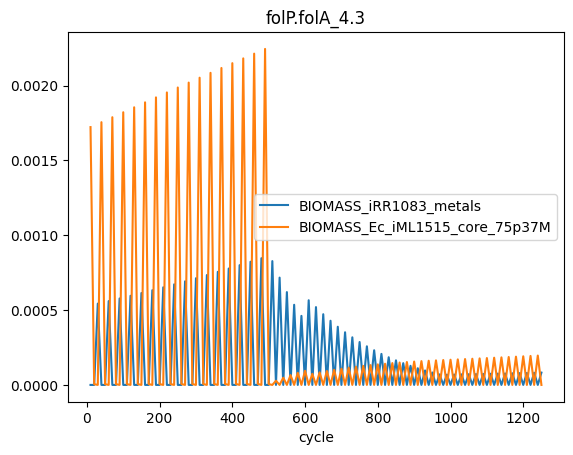

In [ ]:
# key = 'folP.folA_4.3'
# desired_cols = ['BIOMASS_Ec_iML1515_core_75p37M','BIOMASS_iRR1083_metals']
# df1 = pd.DataFrame.from_dict(coculture_dict['S0_coculture_flux_SG'][key]).set_index('cycle')[[desired_cols[1]]]
# df2 = pd.DataFrame.from_dict(coculture_dict['E0_coculture_flux_SG'][key]).set_index('cycle')[[desired_cols[0]]]
pd.concat([df1, df2], axis=1).plot(title=key)

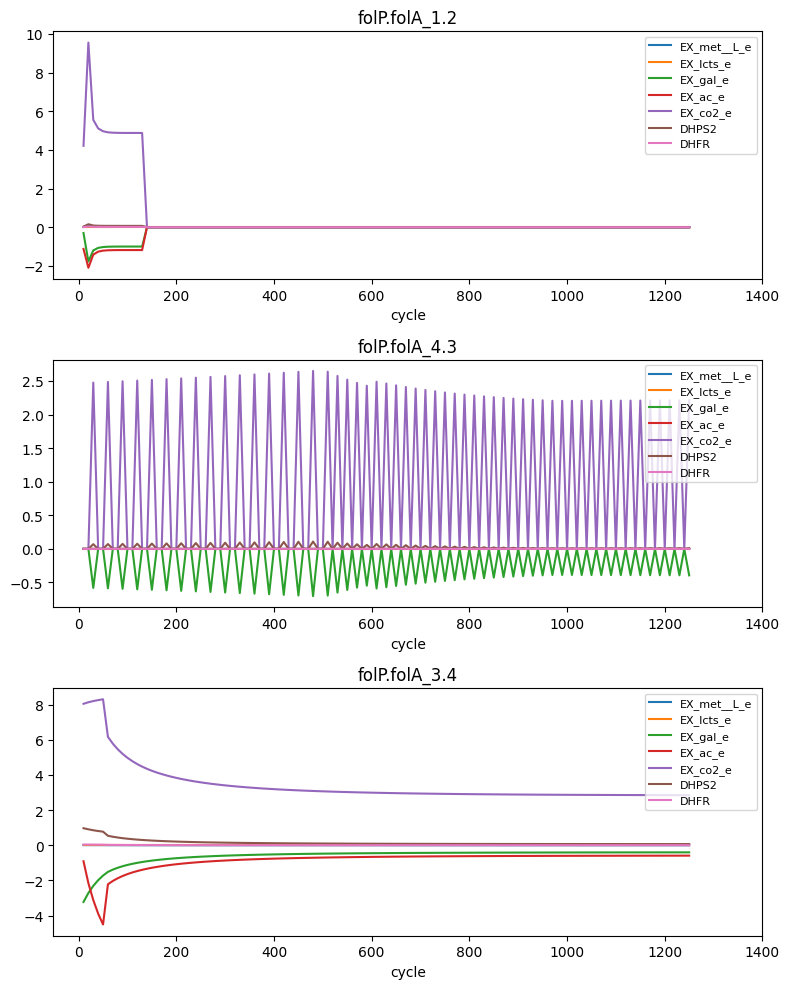

In [ ]:
import matplotlib.pyplot as plt
keys = ['folP.folA_1.2','folP.folA_4.3','folP.folA_3.4']

fig, axs = plt.subplots(len(keys),  1,figsize=(8, 10))
desired_cols = ['EX_met__L_e','EX_lcts_e','EX_gal_e','EX_ac_e', 'EX_co2_e', 'DHPS2','DHFR']
for i, key in enumerate(keys):
    df = pd.DataFrame.from_dict(coculture_dict['S0_coculture_flux_SG'][key]).set_index('cycle')[desired_cols]
    df.plot(y=desired_cols, ax=axs[i], title=key)
    axs[i].set_xlim(right=1400)  # Set x-axis upper limit to 1400
    axs[i].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
desired_df = df.query('1150<=cycle<1250')[desired_cols]
# df.index = ['E0_coculture_flux_SG', 'S0_coculture_flux_SG']
# desired_df.index = ['E0_coculture_flux_SG', 'S0_coculture_flux_SG','E0_coculture_flux_SG', 'S0_coculture_flux_SG','E0_coculture_flux_SG', 'S0_coculture_flux_SG']
desired_df

,cycle,EX_met__L_e,EX_lcts_e,EX_gal_e,EX_ac_e,EX_co2_e,DHPS2,DHFR
114,1150,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
115,1160,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
116,1170,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
117,1180,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
118,1190,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
119,1200,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
120,1210,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
121,1220,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
122,1230,-0.0005,-5.265447,3.578759,5.214625,5.023662,1.660245,0.000576
123,1240,-0.0005,-5.265427,3.578741,5.214596,5.023668,1.660243,0.000576


In [ ]:
df = pd.concat([pd.DataFrame.from_dict(mono_dict[key]['folP.folA_4.3'])
                 for key in ['E0_monoculture_flux_SG', 'S0_monoculture_flux_SG']])
df_filtered = df[df['cycle'] > 700]

desired_cols = ['cycle', 'EX_met__L_e','EX_lcts_e','EX_gal_e','EX_ac_e', 'EX_co2_e', 'DHPS2','DHFR']
df_filtered[desired_cols].mean(), df_filtered[desired_cols].std()

desired_df = df.query('1230<=cycle<1250')[desired_cols]
# df.index = ['E0_coculture_flux_SG', 'S0_coculture_flux_SG']
desired_df.index = ['E0_coculture_flux_SG', 'S0_coculture_flux_SG']
desired_df


KeyboardInterrupt



In [ ]:
df = pd.DataFrame.from_dict(coculture_dict['S0_coculture_flux_SG']['folP.folA_3.4'])
df_filtered = df[df['cycle'] > 0]

desired_cols = ['EX_met__L_e','EX_lcts_e','EX_gal_e','EX_ac_e', 'EX_co2_e', 'DHPS2','DHFR']
df_filtered[desired_cols].apply(['mean','std'])
df[df['cycle']==1230][desired_cols]

,EX_met__L_e,EX_lcts_e,EX_gal_e,EX_ac_e,EX_co2_e,DHPS2,DHFR
245,0.000673,0.0,-0.402684,-0.590522,2.850805,0.067878,0.003012


In [ ]:
lv_pairs = [lv_pair[1].split('.') for lv_pair in flux_compare_df.index.str.split('_')]
lv_pairs = [tuple([int(ele) for ele in lv_pair]) for lv_pair in lv_pairs]
co_flux_compare_df['lv_pairs'] = lv_pairs
# arrange 'Species', 'XG', 'lv_pairs' to front
cols = co_flux_compare_df.columns.tolist()
cols = ['Species', 'XG', 'lv_pairs'] + [col for col in cols if col not in ['Species', 'XG', 'lv_pairs']]
flux_compare_df = co_flux_compare_df[cols]
# desired_cycle.query('culture=="coculture"').merge(flux_compare_df,
#                                                   left_index=True, right_index=True)

flux_compare_df = pd.concat([flux_compare_df, mono_flux_compare_df])
flux_compare_df = join_dfs_using_MI([desired_cycle, flux_compare_df], multi_index=['XG','Gene_inhibition', 'culture','Species'])
flux_compare_df['ICX'] = flux_compare_df.apply(lambda x : get_ICX_from_lv_pair_list(x.alpha_lv_pairs).values(), axis=1)
# flux_compare_df.to_csv('./Data/checkerboard_flux_compare_df.csv')
# flux_compare_df.loc[lv_pair_list][['growth_phase','EX_met__L_e','EX_lcts_e','EX_gal_e','EX_ac_e','EX_ac_e_mean','EX_ac_e_std','EX_co2_e',
#                                                                      'DHPS2','DHFR',  'BIOMASS_Ec_iML1515_core_75p37M','BIOMASS_iRR1083_metals']]


## S0 flux and E0 flux

In [ ]:
import pandas as pd
df = pd.read_csv('./Data/checkerboard_coculture_flux.csv', index_col=0)
# df.col

l = ["S0_coculture_flux_SG","E0_coculture_flux_SG"]
df1 = df.reset_index().query('Items in @l[0] & lv_pair == "folP.folA_0.0"' )[['Items','cycle','EX_gal_e', 'EX_ac_e']][:50]
df2 = df.reset_index().query('Items in @l[1] & lv_pair == "folP.folA_0.0"' )[['Items','cycle','EX_gal_e', 'EX_ac_e']][:50]

df1.merge(df2, on='cycle', suffixes=('_S0', '_E0')).set_index('cycle')
# df1[:50]
df.index.set_names(['Items', 'lv_pair', 'dp'], inplace=True)
df = df.reset_index('dp', drop=True)
# idx.set_names('Items', level=0)

# Maintainance flux

In [ ]:
maintaince_flux = coculture_dict['E0_coculture_flux_SG']['folP.folA_5.5']

# Possible single gene format for checkerboard

In [ ]:
def get_checkerboard_inhibition_SG(gene, lv_pairs):
    # print(gene, lv_pairs)
    mask = [gene == g for g in 'folP.folA'.split('.')]
    if isinstance(lv_pairs, str):
        lv_pairs =ast.literal_eval(lv_pairs)
        
    return ''.join([gene+'_'+str(x) for x, m in zip(lv_pairs, mask) if m]) # should be only element 

alpha_table.reset_index().apply(lambda x: get_checkerboard_inhibition_SG(x.Gene_inhibition, x.lv_pairs), axis=1)

0     folP_0
1     folA_0
2     folP_0
3     folA_1
4     folP_0
       ...  
67    folA_3
68    folP_5
69    folA_4
70    folP_5
71    folA_5
Length: 72, dtype: object